### Dependencies

In [24]:
import kagglehub                                        # pip install kagglehub for Download Dataset
import os                                               # pip install os for path
import tensorflow as tf                                 # pip install tensorflow for build architecture
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import seaborn as sns

### Download Dataset


In [ ]:
# Download latest version
path = kagglehub.dataset_download("drgfreeman/rockpaperscissors")

print("Path to dataset files:", path)

f:\Project\ML Portofolio\Rock Paper Scissors Classifier\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 306M/306M [00:34<00:00, 9.19MB/s] 

Extracting files...


Path to dataset files: C:\Users\User\.cache\kagglehub\datasets\drgfreeman\rockpaperscissors\versions\2


### EDA

In [9]:
path = r"C:\Users\User\.cache\kagglehub\datasets\drgfreeman\rockpaperscissors\versions\2"

In [10]:
# Check the structure of the dataset
!tree {path}

Folder PATH listing
Volume serial number is 000000B1 98EB:3701
C:\USERS\USER\.CACHE\KAGGLEHUB\DATASETS\DRGFREEMAN\ROCKPAPERSCISSORS\VERSIONS\2
����paper
����rock
����rps-cv-images
�   ����paper
�   ����rock
�   ����scissors
����scissors


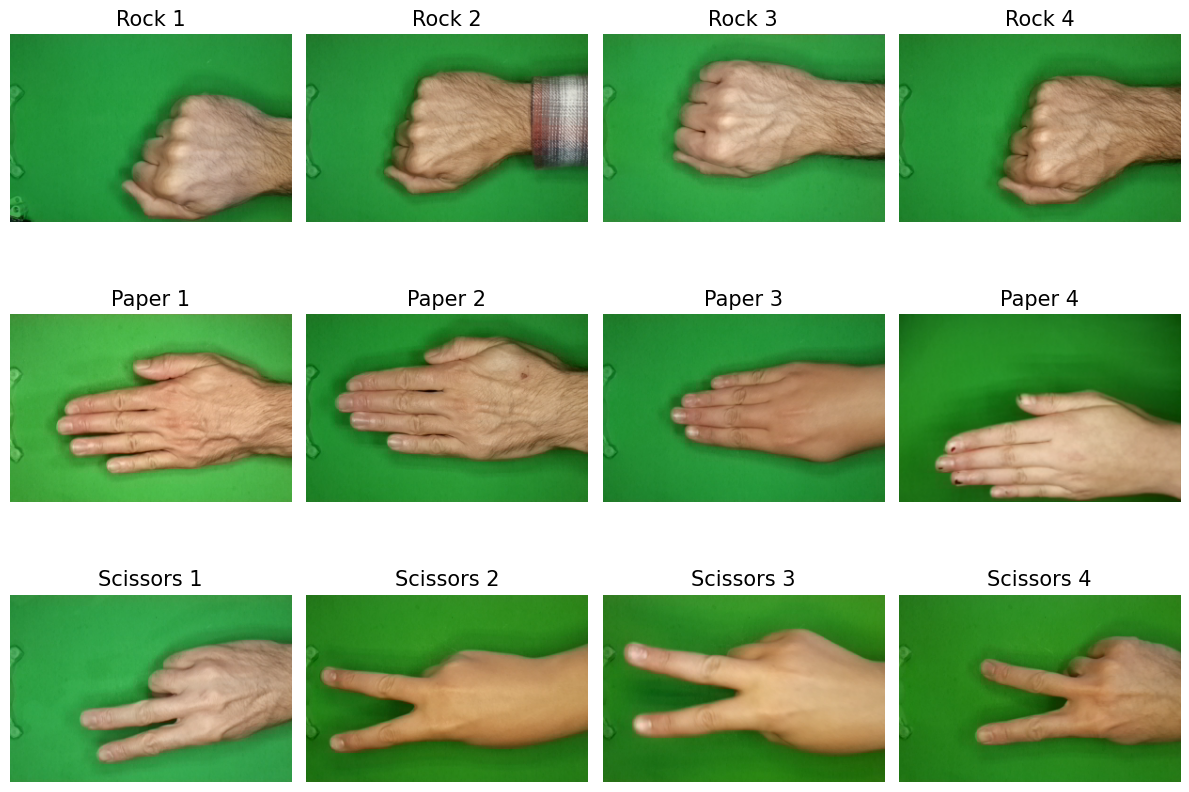

In [11]:
# Show images from the dataset
import matplotlib.pyplot as plt
from PIL import Image

# Define the base path
base_path = path

# The classes we want to display
classes = ['rock', 'paper', 'scissors']

# Create a figure with a grid: 3 rows (classes) x 4 columns (images)
fig, axes = plt.subplots(3, 4, figsize=(12, 9))

for i, label in enumerate(classes):
    class_folder = os.path.join(base_path, label)
    
    # Get first 4 valid image files
    filenames = [f for f in os.listdir(class_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))][:4]
    
    for j, fname in enumerate(filenames):
        img_path = os.path.join(class_folder, fname)
        
        # Open the image using PIL
        img = Image.open(img_path)
        
        # Optional: convert to RGB if images have an alpha channel (RGBA)
        img = img.convert("RGB")
        
        # Display in the subplot grid
        ax = axes[i, j]
        ax.imshow(img)
        ax.set_title(f"{label.capitalize()} {j+1}", fontsize=15)
        ax.axis('off')

plt.tight_layout()
plt.show()

In [12]:
# Gather all file paths and labels
X = [] # This will store the full path to every image
y = [] # This will store the label (0, 1, or 2)

for idx, label in enumerate(classes):
    class_path = os.path.join(base_path, label)

    # List all files in the folder
    images = os.listdir(class_path)
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            X.append(os.path.join(class_path, fname))
            y.append(idx) # Storing index (0, 1, 2) is usually better for models


In [14]:
# Split into Train (80%) and Test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  # Very important: ensures equal class distribution in both sets
)

print(f"Total images: {len(X)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Total images: 2188
Training samples: 1750
Testing samples: 438


In [15]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Convert your split lists into DataFrames
# Note: y labels must be strings for categorical classification in Keras
train_df = pd.DataFrame({'filename': X_train, 'label': [str(i) for i in y_train]})
test_df = pd.DataFrame({'filename': X_test, 'label': [str(i) for i in y_test]})

In [16]:
# Initialize the generator with normalization (scaling pixels 0-255 to 0-1)
datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical'
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filename',
    y_col='label',
    target_size=(150, 150),
    batch_size=32,
    class_mode='categorical',
    shuffle=False # Keep test data in order
)

Found 1750 validated image filenames belonging to 3 classes.
Found 438 validated image filenames belonging to 3 classes.


### Transfer Learning

In [ ]:
# Load a pre-trained model without the top 'head'
base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # 'Freeze' the pre-trained weights

# Build your custom classifier on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),  # Prevents overfitting on small data
    layers.Dense(3, activation='softmax') # 3 classes: Rock, Paper, Scissors
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

C:\Users\User\AppData\Local\Temp\ipykernel_11108\446092910.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(input_shape=(150, 150, 3), include_top=False, weights='imagenet')


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [32]:
# Train the model using the generators
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=test_generator
)

Epoch 1/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8766 - loss: 0.3252 - val_accuracy: 0.9703 - val_loss: 0.0940
Epoch 2/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 51s 855ms/step - accuracy: 0.9737 - loss: 0.0825 - val_accuracy: 0.9772 - val_loss: 0.0694
Epoch 3/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 84s 886ms/step - accuracy: 0.9857 - loss: 0.0511 - val_accuracy: 0.9772 - val_loss: 0.0663
Epoch 4/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 46s 837ms/step - accuracy: 0.9937 - loss: 0.0381 - val_accuracy: 0.9863 - val_loss: 0.0478
Epoch 5/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 42s 764ms/step - accuracy: 0.9937 - loss: 0.0295 - val_accuracy: 0.9863 - val_loss: 0.0374
Epoch 6/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 79s 705ms/step - accuracy: 0.9926 - loss: 0.0245 - val_accuracy: 0.9863 - val_loss: 0.0312
Epoch 7/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 43s 782ms/step - accuracy: 0.9977 - loss: 0.0187 - val_accuracy: 0.9863 - val_loss: 0.0411
Epoch 8/10
55/55 ━━━━━━━━━━━━━━━━━━━━ 44s 806ms/step - accuracy: 0.9971 - loss: 0.0152 - val_accurac

### Evaluate the Model

In [22]:
from sklearn.metrics import confusion_matrix, classification_report

# Get the true labels from the generator
y_true = test_generator.classes

# Predict the probabilities for the test set
# Ensure shuffle=False was set in your test_generator!
predictions = model.predict(test_generator)

# Convert probabilities to class indices (0, 1, or 2)
y_pred = np.argmax(predictions, axis=1)

14/14 ━━━━━━━━━━━━━━━━━━━━ 11s 673ms/step


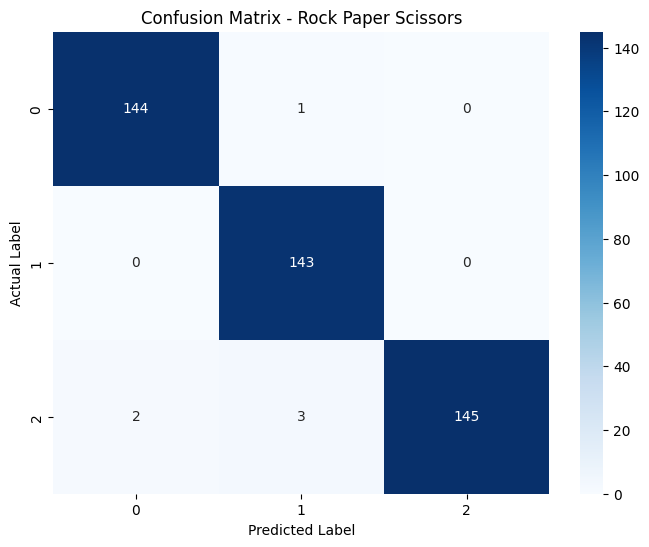

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       145
           1       0.97      1.00      0.99       143
           2       1.00      0.97      0.98       150

    accuracy                           0.99       438
   macro avg       0.99      0.99      0.99       438
weighted avg       0.99      0.99      0.99       438



In [27]:
# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Get the class names (rock, paper, scissors)
class_names = list(test_generator.class_indices.keys())

# Plotting
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Rock Paper Scissors')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# Print the classification report for Precision, Recall, and F1-Score
print(classification_report(y_true, y_pred, target_names=class_names))

### Save/Load Model

In [19]:
# Save the model:
# model.save(r'..\models\rps_model_v1.keras')

# To load it back later:
from tensorflow.keras.models import load_model
model = load_model(r'../models/rps_model_v1.keras')

### Test Model

<>:35: SyntaxWarning: invalid escape sequence '\s'
<>:35: SyntaxWarning: invalid escape sequence '\s'


C:\Users\User\AppData\Local\Temp\ipykernel_8408\2937069987.py:35: SyntaxWarning: invalid escape sequence '\s'
  predict_rps('..\src\Images\SampleTest.png', model)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


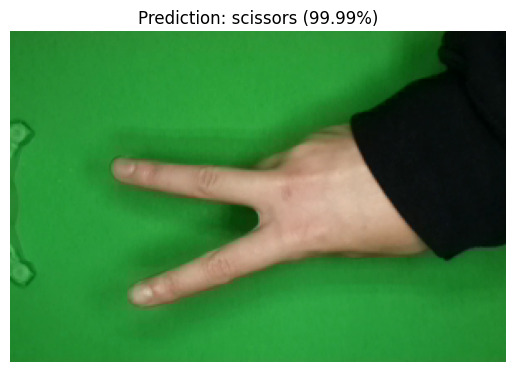

In [29]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def predict_rps(image_path, model):
    # Load the image with PIL
    img = Image.open(image_path).convert('RGB')
    
    # Preprocess: Resize to (150, 150)
    img_resized = img.resize((150, 150))
    
    # Convert to numpy array and Rescale (1/255)
    img_array = np.array(img_resized) / 255.0
    
    # Add Batch Dimension (Model expects (Batch, Height, Width, Channels))
    # This turns shape (150, 150, 3) into (1, 150, 150, 3)
    img_batch = np.expand_dims(img_array, axis=0)
    
    # Make the Prediction
    predictions = model.predict(img_batch)
    
    # 6. Map the result back to labels
    # Assumes the classes are sorted alphabetically: 0: Paper, 1: Rock, 2: Scissors
    class_names = ['paper', 'rock', 'scissors']
    predicted_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_idx] * 100
    
    # Visualization
    plt.imshow(img)
    plt.title(f"Prediction: {class_names[predicted_idx]} ({confidence:.2f}%)")
    plt.axis('off')
    plt.show()

# Usage:
predict_rps('..\src\Images\SampleTest.png', model)